# n_qubits_QVC_Breast_Cancer

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split 
from sklearn.datasets import make_blobs 
from sklearn import svm

import scikitplot as skplt

from h import *
from W_unitary import *
from U_unitary import *
from qiskit_algorithms.optimizers import COBYLA, ADAM, SPSA, SLSQP, POWELL, L_BFGS_B, TNC, AQGD

%matplotlib inline
plt.rcParams['figure.figsize'] = (6,4)
plt.rcParams['figure.dpi'] = 100
sns.set()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.datasets import make_moons
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split 
from sklearn.datasets import make_blobs 
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn import svm

import scipy
from scipy.linalg import expm
import scikitplot as skplt

from h import *
from W_unitary import *
from U_unitary import *
from qiskit_algorithms.optimizers import COBYLA, ADAM, SPSA, SLSQP, POWELL, L_BFGS_B, TNC, AQGD

%matplotlib inline
plt.rcParams['figure.figsize'] = (6,4)
plt.rcParams['figure.dpi'] = 100
sns.set()

In [1]:
dataset = load_breast_cancer()
    
X_train, X_test, Y_train, Y_test = train_test_split(dataset.data, dataset.target, test_size=0.3)

NameError: name 'load_breast_cancer' is not defined

In [ ]:
def PCA(X_train, X_test, y_train, y_test, n_dimensions):
    
    class_labels = [r'Benign', r'Malignant']
    
    # Now the dataset's features will be standardized
    # to fit a normal distribution.
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    # To be able to use this data with the given
    # number of qubits, the data must be broken down from
    # 30 dimensions to `n` dimensions.
    # This is done with Principal Component Analysis (PCA),
    # which finds patterns while keeping variation.
    pca = PCA(n_dimensions).fit(X_train)
    X_train = pca.transform(X_train)
    X_test = pca.transform(X_test)

    # The last step in the data processing is
    # to scale the data to be between -1 and 1
    samples = np.append(X_train, X_test, axis=0)
    minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
    X_train = minmax_scale.transform(X_train)
    X_test = minmax_scale.transform(X_test)

    # Now some sample should be picked to train the model from
    training_input = {key: (X_train[Y_train == k, :])[:len(X_train)] for k, key in enumerate(class_labels)}
    test_input = {key: (X_train[Y_train == k, :])[len(X_train):(len(X_train+len(X_test)))] for k, key in enumerate(class_labels)}

    return X_train, Y_train, training_input, testing_input, class_labels

In [ ]:
n_dimensions = 4
X_train, Y_train, training_input, test_input, class_labels = PCA(training_dataset_size, testing_dataset_size, n_dimensions)#here!

data_train, _ = split_dataset_to_data_and_labels(training_input)
data_test, _ = split_dataset_to_data_and_labels(test_input)

In [ ]:
for k in range(0, n_dimensions):
    x_axis_data = X_train[Y_train == k, 0][:len(X_train)]
    y_axis_data = X_train[Y_train == k, 1][:len(X_train)]

    label = 'Malignant' if k is 1 else 'Benign'
    plt.scatter(x_axis_data, y_axis_data, label=label)
    
plt.title("Breast Cancer Dataset (Dimensionality Reduced With PCA)")
plt.legend()
plt.show()

### helper functions

In [2]:
def make_meshgrid(x1, x2, h=0.2):
    
    x1_min, x1_max = x1.min() - 1, x1.max() + 1
    x2_min, x2_max = x2.min() - 1, x2.max() + 1
    x1x1, x2x2 = np.meshgrid(np.arange(x1_min, x1_max, h), np.arange(x2_min, x2_max, h))
    
    return x1x1, x2x2


def training_split(X_train, y_train, n_batches):
    
    if len(X_train)%n_batches == 0:
        
        X_batches = np.split(X_train, n_batches)
        y_batches = np.split(y_train, n_batches)
        
    else:
        print('Warning: the training set must be divided into equally sized batches')
    
    return X_batches, y_batches


def k_fold_split(X, y, ele_per_split, i):
    
    k_X_train = np.concatenate( (X[:ele_per_split*i, :], X[ele_per_split*(i+1):, :]) )
    k_X_test = X[ele_per_split*i:ele_per_split*(i+1), :]
    
    k_y_train = np.concatenate( (y[:ele_per_split*i], y[ele_per_split*(i+1):]) )
    k_y_test = y[ele_per_split*i:ele_per_split*(i+1)]
    
    return k_X_train, k_X_test, k_y_train, k_y_test

### dataset

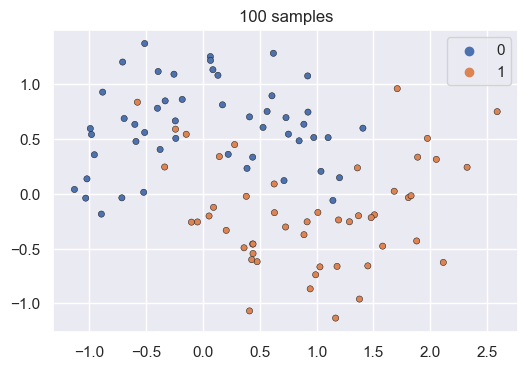

In [3]:
n_samples = 100
X, y = make_moons(n_samples, noise=0.3)

s = 20
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, marker="o", s=s, edgecolor="k", legend=True).set_title(str(n_samples) +" samples")
plt.show()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

n_batches = 7
X_batches, y_batches = training_split(X_train, y_train, n_batches)

## Classical SVM

### linear kernel

In [4]:
linear_kernel = svm.LinearSVC()
linear_kernel.fit(X_train, y_train);

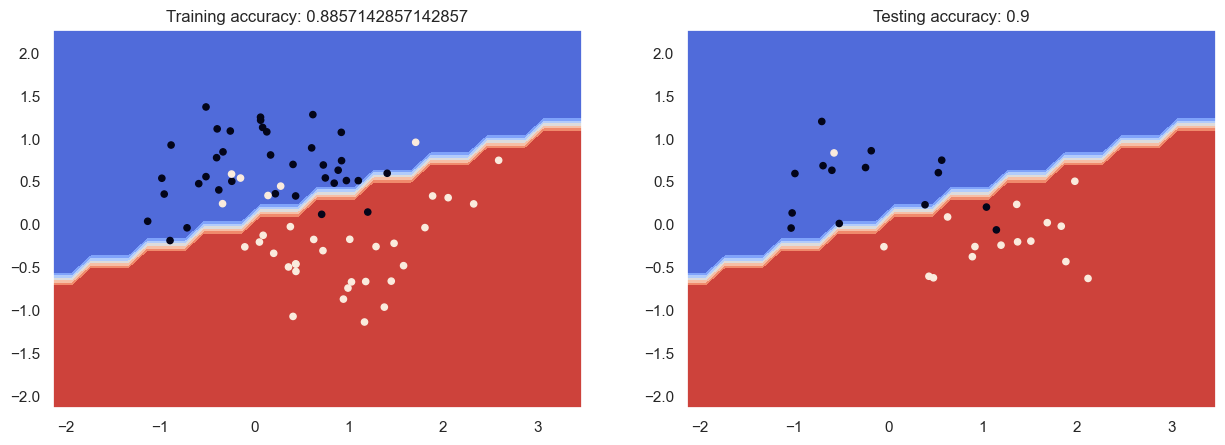

In [5]:
accuracy_train = linear_kernel.score(X_train, y_train)
accuracy_test = linear_kernel.score(X_test, y_test)

X_0, X_1 = X_train[:, 0], X_train[:, 1]
x0x0, x1x1 = make_meshgrid(X_0, X_1)
contours = linear_kernel.predict(np.c_[x0x0.ravel(), x1x1.ravel()])
contours = contours.reshape(x0x0.shape)

fig,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].contourf(x0x0, x1x1, contours, cmap=plt.cm.coolwarm)
ax[0].scatter(X_0, X_1, s=s, c=y_train)
ax[0].set_title('Training accuracy: '+ str(accuracy_train));

ax[1].contourf(x0x0, x1x1, contours, cmap=plt.cm.coolwarm)
ax[1].scatter(X_test[:,0], X_test[:,1], s=s, c=y_test)
ax[1].set_title('Testing accuracy: '+ str(accuracy_test));

### gaussian kernel

In [6]:
gaussian_kernel = svm.SVC(gamma = 'scale')
gaussian_kernel.fit(X_train, y_train);

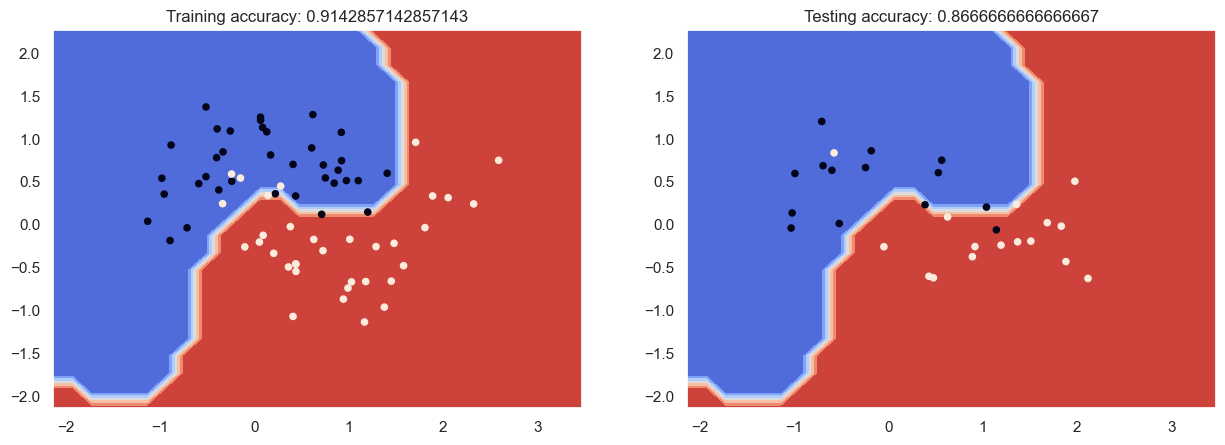

In [7]:
accuracy_train = gaussian_kernel.score(X_train, y_train)
accuracy_test = gaussian_kernel.score(X_test, y_test)

X_0, X_1 = X_train[:, 0], X_train[:, 1]
x0x0, x1x1 = make_meshgrid(X_0, X_1)
contours = gaussian_kernel.predict(np.c_[x0x0.ravel(), x1x1.ravel()])
contours = contours.reshape(x1x1.shape)

fig,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].contourf(x0x0, x1x1, contours, cmap=plt.cm.coolwarm)
ax[0].scatter(X_0, X_1, s=s, c=y_train)
ax[0].set_title('Training accuracy: '+ str(accuracy_train));

ax[1].contourf(x0x0, x1x1, contours, cmap=plt.cm.coolwarm)
ax[1].scatter(X_test[:,0], X_test[:,1], s=s, c=y_test)
ax[1].set_title('Testing accuracy: '+ str(accuracy_test));

## Quantum SVM (explicit approach)

In [8]:
RANDOM_STATE = 42
seed = np.random.seed(RANDOM_STATE)

n = 2
d = 2

init_theta = 2*np.pi*np.random.random(n*d*3)
print('Initial parameters: '+ str(init_theta))

Initial parameters: [2.35330497 5.97351416 4.59925358 3.76148219 0.98029403 0.98014248
 0.3649501  5.44234523 3.77691701 4.44895122 0.12933619 6.09412333]


#### training

In [9]:
def MSE_loss(theta, data, labels):
    
    tmp = []
    for i in range(0, len(labels)):
        if labels[i] == 0:
            tmp.append(-1)
        else:
            tmp.append(1)
    
    predictions = []
    for i in range(0, len(labels)):
        predictions.append(h(data[i], theta, n, d, shots))
    
    error = []
    for i in range(0, len(predictions)):
        parity = predictions[i] - tmp[i]
        error.append(parity)

    norm = np.linalg.norm(error)
    
    return norm

In [ ]:
epochs = n_batches
shots = 1024
theta = init_theta
thetas = []
predictions = []
training_accuracies = []
testing_accuracies = []

for i in tqdm(range(0, epochs)):
    
    prediction = np.zeros(len(y_batches[i]))
    data = X_batches[i]
    labels = y_batches[i]
    
    for j in range(0, len(data)):
        prediction[j] = h(data[j], theta, n, d, shots)
        
        objective_function = lambda theta: MSE_loss(theta, data, labels)
        optimizer = COBYLA(maxiter=100)
        
        theta_opt = optimizer.minimize(objective_function, theta).x
    
    h_subtest = np.zeros(len(y_test))
    for j in range(0, len(y_test)):
        h_subtest[j] = h(X_test[j], theta, n, d, shots)
    
    '''
    for j in range(0, len(labels)):  
        if labels[j] == 0:
            labels[j] = 1
        else:
            labels[j] = -1
    tmp = np.zeros(len(y_test))
    for j in range(0, len(y_test)):
        if y_test[j] == 0:
            tmp[j] = 1
        else:
            tmp[j] = -1
    '''
    
    train_result = 1 - ( (np.abs((sum(2*labels-1-prediction))/2)) / len(labels) )
    test_result = 1 - ( np.abs((sum(2*y_test-1-h_subtest)/2)) / len(y_test) )
    training_accuracies.append(train_result)
    testing_accuracies.append(test_result)
    
    thetas.append(theta)
    predictions.append(prediction)
    theta = theta_opt

 29%|████████████████████████                                                            | 2/7 [01:00<02:32, 30.52s/it]

In [ ]:
print('Training accuracies: '+ str(training_accuracies))
print('Training mean: '+ str(np.mean(training_accuracies)))
print('Testing accuracies: '+ str(testing_accuracies))
print('Testing mean: '+ str(np.mean(testing_accuracies)))

In [ ]:
plt.plot(training_accuracies, color='blue', label='training')
plt.plot(testing_accuracies, color='red', linestyle=':',label='testing')
plt.xlabel('epochs')
plt.ylabel('accuracies (%)')
plt.legend(loc=0, frameon=False)
plt.show()

#### testing

In [ ]:
tmp = []
for i in range(0, len(predictions)):
    for j in range(0, len(predictions[i])):
        tmp.append(predictions[i][j])
'''
new_y_train = np.zeros(len(y_test))
    for j in range(0, len(y_test)):
        if y_test[j] == 0:
            tmp[j] = 1
        else:
            tmp[j] = -1
'''

accuracy_train = 1 - ( (np.abs(sum(2*y_train-1-tmp))/2) / len(y_train) )
print('Training accuracy: '+ str(accuracy_train))

In [ ]:
h_test = []
for i in range(0, len(y_test)):
    h_test.append(h(X_test[i], theta_opt, n, d, shots))

accuracy_test = 1 - (np.abs((sum(2*y_test-1-h_test)/2)) / len(y_test) )
print('Testing accuracy: '+ str(accuracy_test))

In [ ]:
tmp = []
for i in range(0, len(h_test)):
    if h_test[i] == 1:
        tmp.append(0)
    else:
        tmp.append(1)
        
skplt.metrics.plot_confusion_matrix(y_test, tmp, normalize=True, title = 'Moons (before cross-validation)');

### Cross-Validation

### split

In [ ]:
k = 4
assert n_samples%k == 0 #check whether k is a divisor of n_samples
ele_per_split = int(n_samples/k)
#for i in range(k):
    #k_X_train, k_X_test, k_y_train, k_y_test = k_fold_split(X, y, ele_per_split, i)
    #print(k_X_train.shape, k_X_test.shape, k_y_train.shape, k_y_test.shape)

### training

In [ ]:
theta = init_theta
k_thetas = []
k_training_accuracies = []
k_testing_accuracies = []

for i in tqdm(range(k)):
    
    k_X_train, k_X_test, k_y_train, k_y_test = k_fold_split(X, y, ele_per_split, i)

    objective_function = lambda theta: MSE_loss(theta, k_X_train, k_y_train)
    optimizer = COBYLA(maxiter=100)
    
    theta_opt = optimizer.minimize(objective_function, theta).x

    k_thetas.append(theta_opt)

    k_train_predictions = np.zeros(len(k_y_train))
    for j in range(0, len(k_y_train)):
        k_train_predictions[j] = h(k_X_train[j], theta_opt, n, d, shots) 

    k_test_predictions = np.zeros(len(k_y_test))
    for j in range(0, len(k_y_test)):
        k_test_predictions[j] = h(k_X_test[j], theta_opt, n, d, shots) 
        
    k_train_result = 1 - ( (np.abs(sum(2*k_y_train-1-k_train_predictions))/2) / len(k_y_train) )
    k_test_result = 1 - ( (np.abs(sum(2*k_y_test-1-k_test_predictions)/2)) / len(k_y_test) )
    k_training_accuracies.append(k_train_result)
    k_testing_accuracies.append(k_test_result)
    
    '''
    print("Split: ", i+1)
    print("Optimal parameters: "+ str(theta_opt))
    print("Training accuracy: " + str(k_train_result))
    print("Testing accuracy: "+ str(k_test_result))
    '''

In [ ]:
print('Training accuracies: '+ str(k_training_accuracies))
print('Training mean: '+ str(np.mean(k_training_accuracies)))
print('Testing accuracies: '+ str(k_testing_accuracies))
print('Testing mean: '+ str(np.mean(k_testing_accuracies)))

In [ ]:
plt.plot(k_training_accuracies, color='blue', label='training')
plt.plot(k_testing_accuracies, color='red', linestyle=':',label='testing')
plt.xlabel('k')
plt.ylabel('accuracies (%)')
plt.legend(loc=0, frameon=False)
plt.show()

### valuation

In [ ]:
#theta_opt_avg = np.mean(k_thetas, axis=1)
max_testing_accuracy = max(k_testing_accuracies)
index = k_testing_accuracies.index(max_testing_accuracy)
theta_opt = k_thetas[index]

X_val, y_val = make_moons(n_samples//k, noise=0.3)

'''
tmp = []
for i in range(0, len(y_val)):
    if y_val[i] == 0:
        tmp.append(-1)
    else:
        tmp.append(1)
'''

h_val = np.zeros(len(y_val))
for i in range(0, len(y_val)):
    h_val[i] = h(X_val[i], theta_opt, n, d, shots) 

validation_accuracy = 1 - ( (np.abs(sum(2*y_val-1-h_val))/2) / len(y_val) )

print("Optimal average parameters: "+ str(theta_opt))
print("Validation accuracy: "+ str(validation_accuracy))

In [ ]:
tmp = []
for i in range(0, len(h_val)):
    if h_val[i] == 1:
        tmp.append(0)
    else:
        tmp.append(1)
        
skplt.metrics.plot_confusion_matrix(y_val, tmp, normalize=True, title = 'Moons (after cross-validation)');